## LZS interferometry

In [1]:
from joblib import delayed, Parallel

from tqdm.auto import tqdm
import numpy as np

from qutip import *
import matplotlib.pyplot as plt
import scipy
import matplotlib.colors as mcolors
import cmasher as cmr

%matplotlib widget

#### Hamiltoniano del sistema en la base $|L\rangle, |R\rangle$
$H= \begin{pmatrix}
        \epsilon_L(t) & -\tau \\
        -\tau & \epsilon_R
    \end{pmatrix} = \begin{pmatrix}
        \delta(t)/2 & \tau \\
        \tau & -\delta(t)/2
    \end{pmatrix}$

donde $\delta(t)=(\delta_0+A\cos{wt})$

In [2]:
# parámetros y hamiltoniano
w = 1
tau = 0.1*w

t = np.linspace(0, 100 / w, 1000)

H0 = tau*qutip.sigmax() #término independiente de t
H1 = 1/2*qutip.sigmaz() # término dependiente de t

In [3]:
def H1_args(t, args):
    A = args['A']
    delta0 = args['delta0']
    
    return delta0 + A * np.cos(w*t)

In [4]:
H = [H0, [H1, H1_args]]

L = qutip.basis(2,0)
R = qutip.basis(2,1)
psi0 = L

In [5]:
# rangos de los parámetros del sistema
delta0s = np.linspace(-5*w, 5*w, 201)
As = np.linspace(0, 5*w, 200)

In [6]:
# función que calcula un píxel de la imagen final (un pixel equivale a la probabilidad máxima de R para delta y A dados a lo largo de t)
def LZS_pixel(delta0, A):
    args = {'A': A, 'delta0': delta0}
    states = sesolve(H, psi0, t, args=args).states
    
    pRs = []
    for time in range(len(t)):
        pRs.append(np.abs(R.overlap(states[time]))**2)
    pRmax = max(pRs)
    return pRmax

In [7]:
As_mat = []
delta0s_mat = []

for i in range(len(delta0s)):
    for j in range(len(As)):
        As_mat.append(As[j])
        delta0s_mat.append(delta0s[i])

In [8]:
pbar = tqdm(range(len(As_mat)), desc='Calculando LZS')
resultados = Parallel(n_jobs=8)(delayed(LZS_pixel)(delta0s_mat[i], As_mat[i]) for i in pbar)
np.save('LZS01.npy', resultados)

Calculando LZS:   0%|          | 0/40200 [00:00<?, ?it/s]

In [8]:
# es conveniente guardar los resultados para evitar tener que ejecutar el código de nuevo, ya que es muy costoso
resultados = np.load('LZS001.npy')

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

def hex_to_rgba(hex_color):
    """
    Convierte un color en formato hexadecimal a formato RGBA.
    
    Args:
    - hex_color: Color en formato hexadecimal.
    
    Returns:
    - Color en formato RGBA.
    """
    rgb = mcolors.hex2color(hex_color)
    return (*rgb, 1)

def create_custom_cmap(colors, positions):
    """
    Crea un colormap personalizado a partir de una lista de colores y sus posiciones.
    
    Args:
    - colors: Lista de colores en formato hexadecimal.
    - positions: Lista de posiciones normalizadas (entre 0 y 1).
    
    Returns:
    - Colormap personalizado.
    """
    if len(colors) != len(positions):
        raise ValueError("La longitud de 'colors' debe ser igual a la longitud de 'positions'.")
    
    rgba_colors = [hex_to_rgba(color) for color in colors]
    
    cmap_dict = {'red': [], 'green': [], 'blue': []}
    
    for pos, color in zip(positions, rgba_colors):
        for i, channel in enumerate(['red', 'green', 'blue']):
            cmap_dict[channel].append((pos, color[i], color[i]))
    
    return LinearSegmentedColormap('custom_colormap', cmap_dict)

# Definir lista de colores en formato hexadecimal y posiciones
hex_colors = ['w','#C1CFF6','#5F9EA0','#4D8283','#537E83','#DF9595','#E19B9B', '#F17F8A','#F13D70']
positions = [0.0, 0.05, 0.12,0.2,0.28,0.53,0.57,0.72,1]  # Normalizado entre 0 y 1

# Crear el colormap personalizado
custom_cmap = create_custom_cmap(hex_colors, positions)

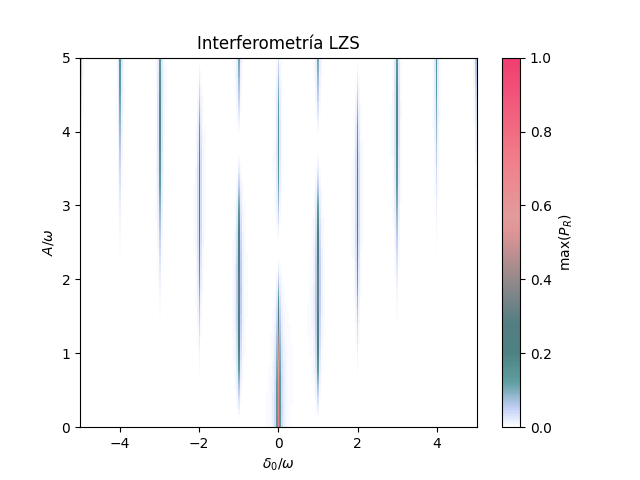

In [10]:
cmap = mcolors.LinearSegmentedColormap.from_list("", ["w",'#D6DAFE',"#9697FF",'#2D2CFF',"#3225FF", '#371EFF',
                                                      '#3A18FF', '#481EFF', '#5223FE', '#5E29FE', '#6B30FE', '#7E3AFC', '#9043FB', 
                                                               '#A14CFA', '#AF53F9', '#D768F5', '#E06CF4', '#EB74F3','#FE80F2'])
resultados_mat = np.array(resultados).reshape((len(delta0s), len(As)))

fig, ax = plt.subplots()
im = ax.imshow(resultados_mat.T, cmap = custom_cmap, origin='lower', aspect='auto',
                interpolation='none', vmin=0, vmax=1,
               extent=[min(delta0s) / w, max(delta0s) / w, min(As) / w, max(As) / w])
plt.ylabel(r'$A/\omega$')
plt.xlabel(r'$\delta_0/\omega$')
plt.title('Interferometría LZS')

cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'$\max(P_R)$')

plt.savefig('./figs/lzs001.pdf')